# Utils

In [1]:
# %matplotlib inline
from scipy.io.wavfile import read
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import scipy
import IPython
from scipy.interpolate import interp1d
from scipy.signal import spectrogram
import matplotlib.animation as animation
import pandas as pd
from PIL import Image
import colorsys
from copy import copy
from tqdm import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
from scipy.ndimage import rotate

def setup_graph(title='', x_label='', y_label='', fig_size=None):
    fig = plt.figure()
    if fig_size != None:
        fig.set_size_inches(fig_size[0], fig_size[1])
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

def scalar_linear_transform(s, s_range=[0,1], map_range=[380,750]):
    transformer = interp1d(s_range,map_range)
    return transformer(s)
    
def array_linear_transform(arr, arr_range=None, map_range=[380,750]):
    if arr_range is None:
        arr_range = [int(np.min(arr)-1), int(np.max(arr)+1)]
    transformer = interp1d(arr_range,map_range)
    return transformer(arr)

'''
    == A few notes about color ==

    Color   Wavelength(nm) Frequency(THz)
    Red     620-750        484-400
    Orange  590-620        508-484
    Yellow  570-590        526-508
    Green   495-570        606-526
    Blue    450-495        668-606
    Violet  380-450        789-668

    f is frequency (cycles per second)
    l (lambda) is wavelength (meters per cycle)
    e is energy (Joules)
    h (Plank's constant) = 6.6260695729 x 10^-34 Joule*seconds
                         = 6.6260695729 x 10^-34 m^2*kg/seconds
    c = 299792458 meters per second
    f = c/l
    l = c/f
    e = h*f
    e = c*h/l

    List of peak frequency responses for each type of 
    photoreceptor cell in the human eye:
        S cone: 437 nm
        M cone: 533 nm
        L cone: 564 nm
        rod:    550 nm in bright daylight, 498 nm when dark adapted. 
                Rods adapt to low light conditions by becoming more sensitive.
                Peak frequency response shifts to 498 nm.

'''

def wavelength_to_rgb(wavelength, gamma=0.8):

    '''This converts a given wavelength of light to an 
    approximate RGB color value. The wavelength must be given
    in nanometers in the range from 380 nm through 750 nm
    (789 THz through 400 THz).

    Based on code by Dan Bruton
    http://www.physics.sfasu.edu/astro/color/spectra.html
    '''

    wavelength = float(wavelength)
    if wavelength >= 380 and wavelength <= 440:
        attenuation = 0.3 + 0.7 * (wavelength - 380) / (440 - 380)
        R = ((-(wavelength - 440) / (440 - 380)) * attenuation) ** gamma
        G = 0.0
        B = (1.0 * attenuation) ** gamma
    elif wavelength >= 440 and wavelength <= 490:
        R = 0.0
        G = ((wavelength - 440) / (490 - 440)) ** gamma
        B = 1.0
    elif wavelength >= 490 and wavelength <= 510:
        R = 0.0
        G = 1.0
        B = (-(wavelength - 510) / (510 - 490)) ** gamma
    elif wavelength >= 510 and wavelength <= 580:
        R = ((wavelength - 510) / (580 - 510)) ** gamma
        G = 1.0
        B = 0.0
    elif wavelength >= 580 and wavelength <= 645:
        R = 1.0
        G = (-(wavelength - 645) / (645 - 580)) ** gamma
        B = 0.0
    elif wavelength >= 645 and wavelength <= 750:
        attenuation = 0.3 + 0.7 * (750 - wavelength) / (750 - 645)
        R = (1.0 * attenuation) ** gamma
        G = 0.0
        B = 0.0
    else:
        R = 0.0
        G = 0.0
        B = 0.0
#     R *= 255
#     G *= 255
#     B *= 255
#     return (int(R), int(G), int(B))
    return (R, G, B)

def array_to_rgb(arr):    
    return list(map(wavelength_to_rgb, arr))

def discretize_transform(arr, out_len, transform):
    bin_size = len(arr)//out_len
    temp = []
    s = 0
    for i in range(out_len):
        temp.append(transform(arr[s:s+bin_size]))
        s = s+bin_size
    return temp



def jpg_image_to_array(image_path):
  """
  Loads JPEG image into 3D Numpy array of shape 
  (width, height, channels)
  """
  with Image.open(image_path) as image:         
    im_arr = np.fromstring(image.tobytes(), dtype=np.uint8)
    im_arr = im_arr.reshape((image.size[1], image.size[0], 3))                                   
  return im_arr

def im_mask_by_wavelength(im, im_wavelength, wave_range):
    im_new = copy(im)
    new_alphas = im_new[...,-1] * 1
    wave_min, wave_max = wave_range
    new_alphas[np.logical_or((im_wavelength < wave_min),(im_wavelength > wave_max))] = 0.3
    im_new[...,-1] = new_alphas
    return im_new

def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial

    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

# Music transform

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


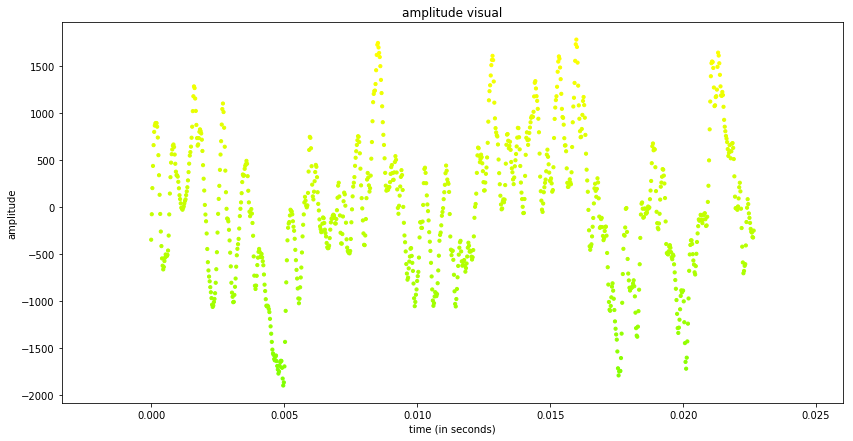

In [2]:
(sample_rate, input_signal) = scipy.io.wavfile.read("./btv_clip.wav")
input_signal = input_signal.reshape(-1,1).T[0]
time_array = np.arange(0, len(input_signal)/sample_rate, 1/sample_rate)

setup_graph(title='amplitude visual', x_label='time (in seconds)', y_label='amplitude', fig_size=(14,7))
_ = plt.scatter(time_array[:1000], input_signal[:1000], s =10, c=array_to_rgb(array_linear_transform(input_signal)[:1000]))

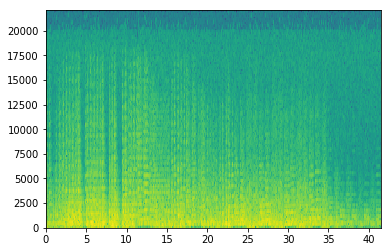

In [3]:
_ = plt.specgram(input_signal, Fs=sample_rate)

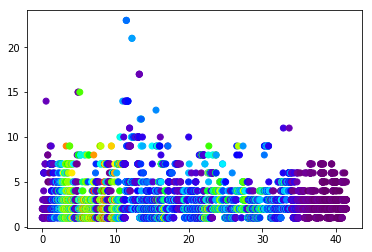

In [4]:
f, t, Sxx = spectrogram(input_signal,sample_rate)
dis_amplitude = discretize_transform(input_signal, len(t), lambda x: np.max(x))
cs = array_to_rgb(array_linear_transform(dis_amplitude))
# setup_graph(title='frequency visual', x_label='time (in seconds)', y_label='frequency', fig_size=(14,7))
freqs = np.argmax(Sxx, axis=0)
_ = plt.scatter(t, freqs, c=cs)

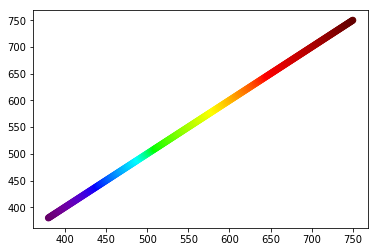

In [5]:
x= np.linspace(380,750,750-380)
y=np.linspace(380,750,750-380)
cs = np.linspace(380,750,750-380)
rgbs = array_to_rgb(array_linear_transform(cs))
plt.scatter(x,y,c=rgbs)

# Image Transform

In [6]:
!rm -rf *.mp4

In [7]:
!ls

autumn.wav    mad2.jpg		play_routine.ipynb  wave_brain.npy
bowl.jpg      mad.jpg		play_routine.py     wave_mad2.npy
brain.jpg     play-Copy1.ipynb	spring.wav	    wave_mad.npy
btv_clip.wav  play.ipynb	summer.wav	    winter.wav
fast.wav      play.py		wave_bowl.npy


In [8]:
im = jpg_image_to_array('./brain.jpg')
# im_wavelength = np.apply_along_axis(lambda x: scalar_linear_transform(colorsys.rgb_to_hsv(*tuple(x))[0]), 2, im)
# np.save('./wave_mad2.npy', im_wavelength)
im_wavelength = np.load('./wave_brain.npy')
im = np.dstack((im/255, 1 * np.ones(im.shape[:2])))

# cdict = {
#   'red'  :  ( (0.0, 0.25, .25), (0.02, .59, .59), (1., 1., 1.)),
#   'green':  ( (0.0, 0.0, 0.0), (0.02, .45, .45), (1., .97, .97)),
#   'blue' :  ( (0.0, 1.0, 1.0), (0.02, .75, .75), (1., 0.45, 0.45))
# }

def create_wave(wave_range=(300, 700)):
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.set_facecolor('xkcd:black')
    im_new = im_mask_by_wavelength(im, im_wavelength, wave_range)    
    im_t = ax.imshow(im_new)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
#     divider = make_axes_locatable(ax)
#     cax = divider.append_axes('right',size='5%',pad=0.05)
#     cm = mpl.colors.LinearSegmentedColormap('jet', cdict, 1024)
# #     cbar = mpl.colorbar.ColorbarBase(ax, cmap=cm, norm=mpl.colors.Normalize(vmin=-2, vmax=2))
#     plt.colorbar(im_t, cax=cax)
    return im_t

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:140: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


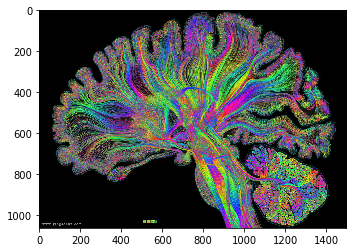

In [9]:
plt.imshow(im)

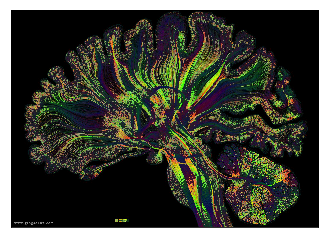

In [10]:
create_wave((300,500))

# Animate

In [11]:
fps = 10
smooth_window = 1001
sound_length_s = int(len(input_signal)/sample_rate) + 1
buffer_image_color_range = 150

In [12]:
freqs_wave_range = discretize_transform(array_linear_transform(savitzky_golay(freqs, smooth_window, 4)), 
                                        fps * sound_length_s, np.max)
mag_wav_range = discretize_transform(array_linear_transform(savitzky_golay(dis_amplitude, smooth_window, 4)),
                                     fps * sound_length_s, np.max)
waves_spectro = []
inter_ind = Sxx.shape[1] // (fps * sound_length_s)
s_ind = 0
for _ in range(len(mag_wav_range)):
    waves_spectro.append(Sxx[:,s_ind])
    s_ind += inter_ind

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1)
ax,ax2 = axes
ax.set_facecolor('xkcd:black')
ax2.set_facecolor('xkcd:black')
# ax.axes.get_xaxis().set_visible(False)
# ax.axes.get_yaxis().set_visible(False)

im_q = []
im_m = []

s_ind = 0

for i in tqdm(freqs_wave_range[:10]):
    temp = im_mask_by_wavelength(im, im_wavelength, (i-buffer_image_color_range,i))
    _ = ax.imshow(temp, animated=True)    
    _, = ax2.plot(waves_spectro[s_ind], animated=True)
    im_q.append([_])
    s_ind += 1

# s_ind = 0
    
# for i in tqdm(mag_wav_range):
#     temp = im_mask_by_wavelength(im, im_wavelength, (i-buffer_image_color_range/2,i))
#     _ = ax.imshow(temp, animated=True)    
#     _ = ax2.plot(waves_spectro[s_ind], animated=True)
#     im_m.append([_])
#     s_ind += 1
    

In [29]:
ani_f = animation.ArtistAnimation(fig, im_q, interval=50, blit=True,
                                repeat_delay=1000)
# ani_m = animation.ArtistAnimation(fig, im_m, interval=50, blit=True,
#                                 repeat_delay=1000)

In [ ]:
from IPython.display import HTML
HTML(ani_f.to_jshtml())

In [23]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=10, metadata=dict(artist='Me'), bitrate=1800)#, codec="libx264")

In [24]:
!rm -rf *.mp4

In [25]:
ani_f.save('brain_freq.mp4', writer=writer)
# ani_m.save('brain_mag.mp4', writer=writer)

KeyboardInterrupt: 

In [ ]:
!ffmpeg -i brain_freq.mp4 -i btv_clip.wav -c:v copy -c:a aac -strict experimental brain_freq_music.mp4

In [ ]:
# !ffmpeg -i brain_mag.mp4 -i btv_clip.wav -c:v copy -c:a aac -strict experimental brain_mag_music.mp4